# Refine orientation of naphthalene molecule

Simulate PDF with separate inter and intramolecular displacement parameters.

## initialization

We start with some necessary imports from diffpy packages and define a convenience function for plotting the PDF fit.
It is safe to skip to the [next section](#global-constants)."

In [1]:
# use `print()` function as in Python 3
from __future__ import print_function

# notebook plotting setup
%matplotlib notebook
import matplotlib
# make figures smaller
matplotlib.rc('figure', figsize=(5, 3.75))
from matplotlib.pyplot import subplots

# numerical math and optimization
import numpy as np
from scipy.optimize import leastsq

# srfit PDF fitting objects
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.fitbase import FitRecipe, FitResults, Calculator

## global constants

In [2]:
# the initial CIF structure
g_cif = "naphthalene.cif"
# offset of difference curve in PDF plot
g_diff_baseline = -1

## define several helper functions

In [3]:
def myLoadCrystal(filename):
    "Load pyobjcryst.Crystal object from a CIF file."
    from pyobjcryst.crystal import CreateCrystalFromCIF
    with open(filename, 'rb') as fp:
        rv = CreateCrystalFromCIF(fp, oneScatteringPowerPerElement=True)
    return rv


def getCrystalWithMolecule(ciffilename):
    """
    Load the CIF file and group all scatterers as one Molecule.

    This assumes the asymmetric unit is a single whole Molecule,
    i.e., there are no other molecules or independent atoms in
    the crystal and the molecule does not need to be
    symmetry-expanded.
    """
    from pyobjcryst.molecule import Molecule
    # center of the molecule in fractional coordinates
    xyzmol = np.array([0.0, 0.0, 0.0])
    crst = myLoadCrystal(ciffilename)
    mol = Molecule(crst, "mol")
    for i in reversed(range(crst.GetNbScatterer())):
        a = crst.GetScatterer(i)
        xyzm = np.array([a.X, a.Y, a.Z]) - xyzmol
        xc, yc, zc = crst.FractionalToOrthonormalCoords(*xyzm)
        mol.AddAtom(xc, yc, zc, a.GetScatteringPower(), a.GetName())
        crst.RemoveScatterer(a)
    crst.AddScatterer(mol)
    mol.X, mol.Y, mol.Z = xyzmol
    return crst


class quatzero(Calculator):
    """Return the zero-th component of normalized quaternion.
    """

    def __call__(self, q1, q2, q3):
        ssq = q1**2 + q2**2 + q3**2
        q0 = np.sqrt(1.0 - ssq) if ssq < 1 else 0.0
        return q0

# end of quatzero


def plotrecipe(axis, rec, what='obs, calc, diff'):
    choice = set(what.replace(',', ' ').split())
    r = rec.pcnt.r.value
    gobs = rec.pcnt.y.value
    gcalc = rec.pcnt.evaluate()
    gdiff = gobs - gcalc
    yall = [('obs', gobs),
            ('calc', gcalc),
            ('diff', gdiff + g_diff_baseline)]
    pargs = sum([(r, y) for n, y in yall if n in choice], ())
    rv = axis.plot(*pargs)
    if 'calc' in choice and 'diff' in choice:
        rv[-1].set_color(rv[-2].get_color())
    return rv

## define PDF model composed of inter and intra-molecular components

In [4]:
pcnt = PDFContribution('pcnt')
pcnt.loadData('naphthalene.gr')
pcnt.qdamp = 0.06
pcnt.setCalculationRange(1.1, 25)
# intra-molecular contribution from one molecule:
crst = getCrystalWithMolecule(g_cif)
mol = crst.GetScatterer("mol")
pcnt.addStructure('mol', mol, periodic=False)
# inter-molecular contributions (wide)
wcrst = getCrystalWithMolecule(g_cif)
wmol = wcrst.GetScatterer('mol')
pcnt.addStructure('wcrst', wcrst, periodic=True)
pcnt.addStructure('wmol', wmol, periodic=False)
pcnt.setEquation('scale * (mol + wcrst - wmol)')

# speed up simulation by using parallel jobs.
pcnt.wcrst.parallel(4)

## define FitRecipe for this PDF model

In [5]:
# define FitRecipe for this organic crystal
ocfit = FitRecipe()
ocfit.clearFitHooks()
ocfit.addContribution(pcnt)

# expose the overall data scale
ocfit.addVar(ocfit.pcnt.scale, name='scale', value=0.1)
ocfit.addVar(ocfit.pcnt.qdamp, name='qdamp')

# expose unit cell parameters
pwcrst = ocfit.pcnt.wcrst.phase
ocfit.addVar(pwcrst.a)
ocfit.addVar(pwcrst.b)
ocfit.addVar(pwcrst.c)
# objcryst uses radians for cell angle beta, but let us refine
# in degrees.
ocfit.newVar('beta', value=np.degrees(pwcrst.beta.value))
ocfit.constrain(pwcrst.beta, 'radians(beta)')

# objcryst links all atoms of the same type to one scattering power
# with common Biso.  It is thus sufficient to constrain just one of
# those.

# first let's ensure there are only 2 independent scattering powers
# for "C" and "H" in the CIF file.
assert 2 == crst.GetScatteringPowerRegistry().GetNb(), \
    "unexpected number of atom species"

# expose isotropic displacement parameters for carbon and hydrogen
# in the molecule.  CIF file has sites labeled "C1", "H1" so we can
# refer to them by those names.
pmol = ocfit.pcnt.mol.phase
ocfit.addVar(pmol.C1.Biso, name='bisoC', value=1.0)
ocfit.restrain('bisoC', lb=0.02, sig=1e-4)
# hydrogen gives negligible contribution, so we keep them constant
ocfit.addVar(pmol.H1.Biso, name='bisoH', value=1, fixed=True)

# for intra-molecular component we use the same binter value for all atoms:
ocfit.addVar(pwcrst.mol.C1.Biso, name='binter', value=10)
ocfit.constrain(pwcrst.mol.H1.Biso, 'binter')

# expose rotation quaternions for the molecule
pwmol = ocfit.pcnt.wcrst.phase.mol
ocfit.addVar(pwmol.q1, name='wq1')
ocfit.addVar(pwmol.q2, name='wq2')
ocfit.addVar(pwmol.q3, name='wq3')

# constrain q0 so we have normalized quaternion.
# first define a function "fixq0" that calculates q0 from [q1, q2, q3]
ocfit.registerCalculator(quatzero('fixq0'), argnames=[])
ocfit.constrain(pwmol.q0, 'fixq0(wq1, wq2, wq3)')

## fix all variables and show the initial residual

In [6]:
ocfit.fix('all')
ocfit.free('scale')
ocfit.scalarResidual()
print("== INITIAL ==\n")
print(FitResults(ocfit))

== INITIAL ==

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       10.43700850
Contributions  10.43700850
Restraints     0.00000000
Chi2           10.43700850
Reduced Chi2   0.00436512
Rw             0.56522530

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
scale  1.00000000e-01 +/- 2.04728043e-02

Fixed Variables
------------------------------------------------------------------------------
a       8.25600000e+00
b       5.98300000e+00
beta    1.22729000e+02
binter  1.00000000e+01
bisoC   1.00000000e+00
bisoH   1.00000000e+00
c       8.67700000e+00
qdamp   6.00000000e-02
wq1     0.00000000e+00
wq2     0.00000000e+00
wq3     0.00000000e+00

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
No

## refine cell parameters and displacement factors

In [7]:
ocfit.free('a', 'b', 'c')
ocfit.free('bisoC', 'binter')
leastsq(ocfit.residual, ocfit.values)
print("== INTERMEDIATE ==\n")
print(FitResults(ocfit))

== INTERMEDIATE ==

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       1.13505177
Contributions  1.13505177
Restraints     0.00000000
Chi2           1.13505177
Reduced Chi2   0.00047571
Rw             0.18639807

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
a       8.25930426e+00 +/- 1.45574961e-01
b       5.97087494e+00 +/- 1.88965022e-01
binter  4.00770360e+00 +/- 3.00580690e+00
bisoC   1.00692095e-01 +/- 1.60461551e-01
c       8.62335993e+00 +/- 2.99869773e-01
scale   6.07775632e-02 +/- 2.11016030e-02

Fixed Variables
------------------------------------------------------------------------------
beta   1.22729000e+02
bisoH  1.00000000e+00
qdamp  6.00000000e-02
wq1    0.00000000e+00
wq2    0.00000000e+00
wq3    0.00000000e+00

Variable Correlations greater than 25% (Correlation

## refine the orientation quaternion for the molecule

In [8]:
ocfit.free('wq1', 'wq2', 'wq3')
leastsq(ocfit.residual, ocfit.values)
print("== REFINED ==\n")
print(FitResults(ocfit))

== REFINED ==

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       1.11814903
Contributions  1.11814903
Restraints     0.00000000
Chi2           1.11814903
Reduced Chi2   0.00046922
Rw             0.18500498

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
a       8.25653175e+00 +/- 1.49691571e-01
b       5.97225210e+00 +/- 2.00729366e-01
binter  4.02721681e+00 +/- 3.05779726e+00
bisoC   1.01798062e-01 +/- 1.61042426e-01
c       8.62938897e+00 +/- 3.25759814e-01
scale   6.09873290e-02 +/- 2.13045706e-02
wq1     -1.47642434e-03 +/- 7.68690456e-02
wq2     -6.29884037e-03 +/- 5.53338759e-02
wq3     8.01771991e-03 +/- 7.31873438e-02

Fixed Variables
------------------------------------------------------------------------------
beta   1.22729000e+02
bisoH  1.00000000e+00
qdamp  6.00000000

## rotate molecule away from the minimum

== MISORIENTED ==

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       3.70108160
Contributions  3.70108160
Restraints     0.00000000
Chi2           3.70108160
Reduced Chi2   0.00154857
Rw             0.33658744

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
bisoC  7.72030102e-02 +/- 1.36123117e-01
scale  5.65945783e-02 +/- 1.30118994e-02

Fixed Variables
------------------------------------------------------------------------------
a       8.25653175e+00
b       5.97225210e+00
beta    1.22729000e+02
binter  4.02721681e+00
bisoH   1.00000000e+00
c       8.62938897e+00
qdamp   6.00000000e-02
wq1     1.00000000e-01
wq2     -6.29884037e-03
wq3     8.01771983e-03

Variable Correlations greater than 25% (Correlations invalid)
-------------------------------------------------------------

<IPython.core.display.Javascript object>


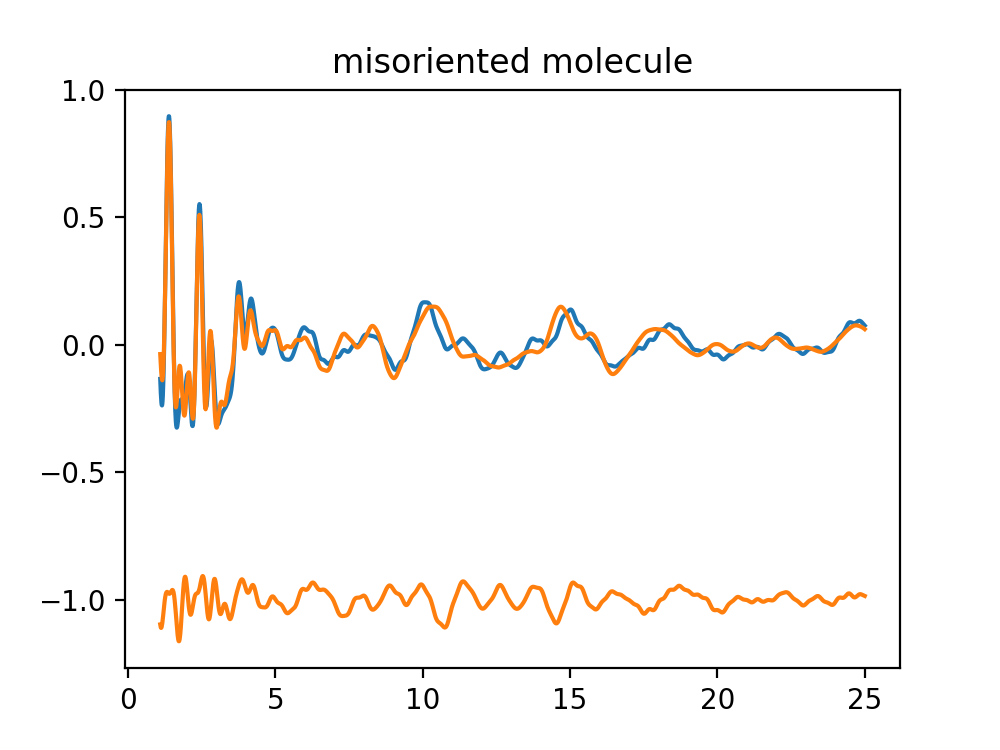

In [9]:
# rotate molecule away from the minimum
ocfit.wq1 << 0.1
ocfit.fix('a', 'b', 'c', 'binter', 'wq1', 'wq2', 'wq3')
leastsq(ocfit.residual, ocfit.values)
print("== MISORIENTED ==\n")
print(FitResults(ocfit))
fig1, ax1 = subplots()
plotrecipe(ax1, ocfit)
ax1.set_title('misoriented molecule');

## refine molecule orientation to return to the correct structure

== ORIENTED BACK ==

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       1.11814903
Contributions  1.11814903
Restraints     0.00000000
Chi2           1.11814903
Reduced Chi2   0.00046843
Rw             0.18500498

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
bisoC  1.01797966e-01 +/- 1.36123631e-01
scale  6.09873137e-02 +/- 1.33205076e-02
wq1    -1.47531473e-03 +/- 6.96313632e-02
wq2    -6.29909748e-03 +/- 5.38986231e-02
wq3    8.01797909e-03 +/- 7.06878275e-02

Fixed Variables
------------------------------------------------------------------------------
a       8.25653175e+00
b       5.97225210e+00
beta    1.22729000e+02
binter  4.02721681e+00
bisoH   1.00000000e+00
c       8.62938897e+00
qdamp   6.00000000e-02

Variable Correlations greater than 25% (Correlations invalid)
----

<IPython.core.display.Javascript object>


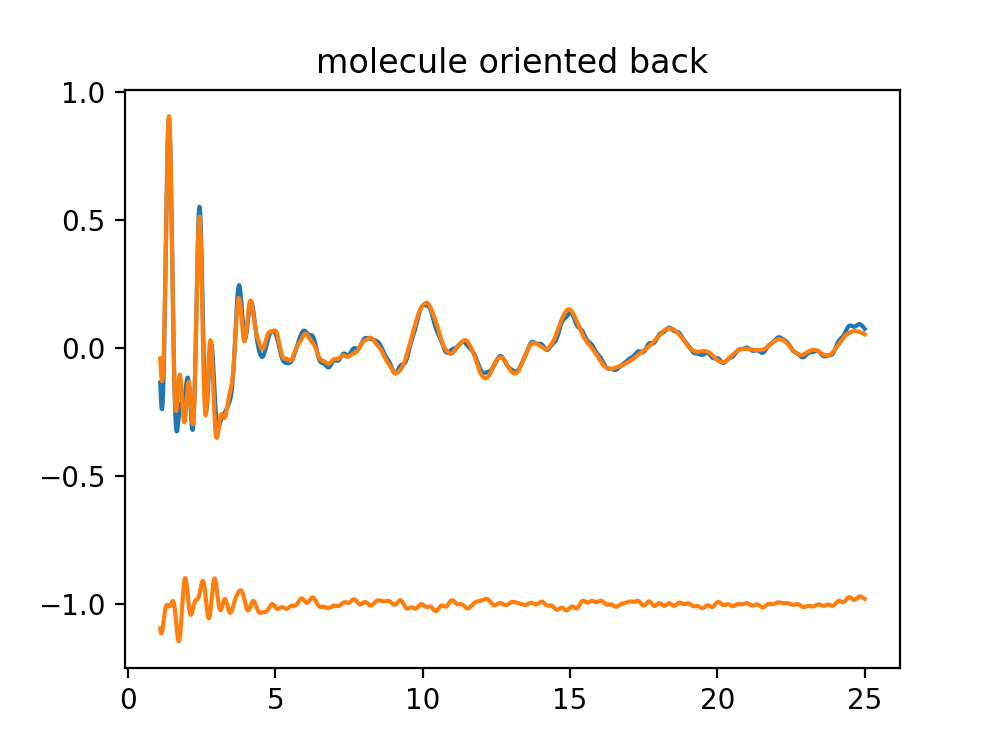

In [10]:
ocfit.free('wq1', 'wq2', 'wq3')
leastsq(ocfit.residual, ocfit.values)
print("== ORIENTED BACK ==\n")
print(FitResults(ocfit))
fig2, ax2 = subplots()
plotrecipe(ax2, ocfit);
ax2.set_title('molecule oriented back');